In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1)

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
  mean_absolute_error,
  mean_squared_error,
  mean_absolute_percentage_error,
  accuracy_score,
  f1_score
)

from sklearn.utils import resample

import random

In [2]:
sorted([[1, 2, 1], [2, 2], [1, 3, 1, 1]])

[[1, 2, 1], [1, 3, 1, 1], [2, 2]]

In [3]:
n_classes = 10

X, y = load_digits(n_class=n_classes, return_X_y=True)
to_sample = False

In [4]:
# sampled = resample(np.hstack((X, y.reshape(y.shape[0], 1))), n_samples= 16 * y.shape[0])
# sampled.shape

In [5]:
# X, y = sampled[:, :-1], np.array(sampled[:, -1], dtype=np.int32)
X.shape, y.shape, np.unique(y)

((1797, 64), (1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

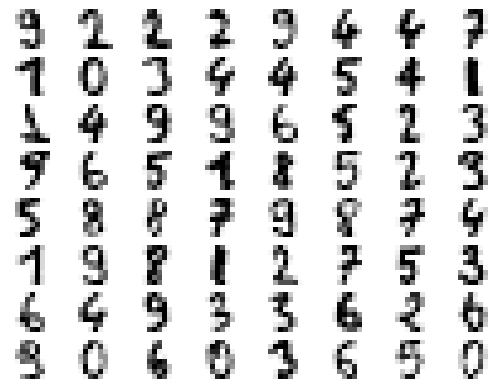

In [6]:
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(X[random.randint(0, X.shape[0])].reshape(8, 8), cmap='Greys')

In [7]:
X.shape, y.shape

((1797, 64), (1797,))

In [8]:
n_features = X.shape[1]
n_targets = n_classes

In [9]:
%load_ext autoreload
%autoreload

In [10]:
from common.distributor import UniformDataDistributor, DataDistributor
from optimization.federative.fedavg import FederatedAveraging, Model
from optimization.federative.scaffold import Scaffold

In [11]:
from function.vanilla import MSERidgeLinear, MSELassoLinear
from function.torch import TorchFunction

In [12]:
import torch

In [13]:
torch_model = torch.nn.Sequential(
  torch.nn.Linear(n_features, 32),
  torch.nn.Sigmoid(),
  torch.nn.Linear(32, n_targets),
  torch.nn.Softmax(dim=-1)
)
function = TorchFunction(torch_model, torch.nn.CrossEntropyLoss())

torch_enable = True

In [14]:
distributor = DataDistributor(test_size=0.2, server_fraction=0.2)

In [15]:
from pipeline.pipeline import Pipeline

In [16]:
from common.reducers import mean, max, min

In [33]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
threadpool = None


Scaffold for parameters: {'n_clients': 16, 'iid_fraction': 0.1, 'clients_fraction': 0.25, 'batch_size': 128, 'epochs': 196, 'rounds': 24, 'eta': 0.25}:


learning:   0%|          | 0/24 [00:00<?, ?it/s]

learning: 100%|██████████| 24/24 [00:05<00:00,  4.19it/s]


accuracy : 0.9305555555555556
f1_score : 0.9346633758398464

FederatedAveraging for parameters: {'n_clients': 16, 'iid_fraction': 0.1, 'clients_fraction': 0.25, 'batch_size': 128, 'epochs': 196, 'rounds': 24, 'eta': 0.25}:


learning: 100%|██████████| 24/24 [00:05<00:00,  4.42it/s]


accuracy : 0.8472222222222222
f1_score : 0.8471651623612408
done


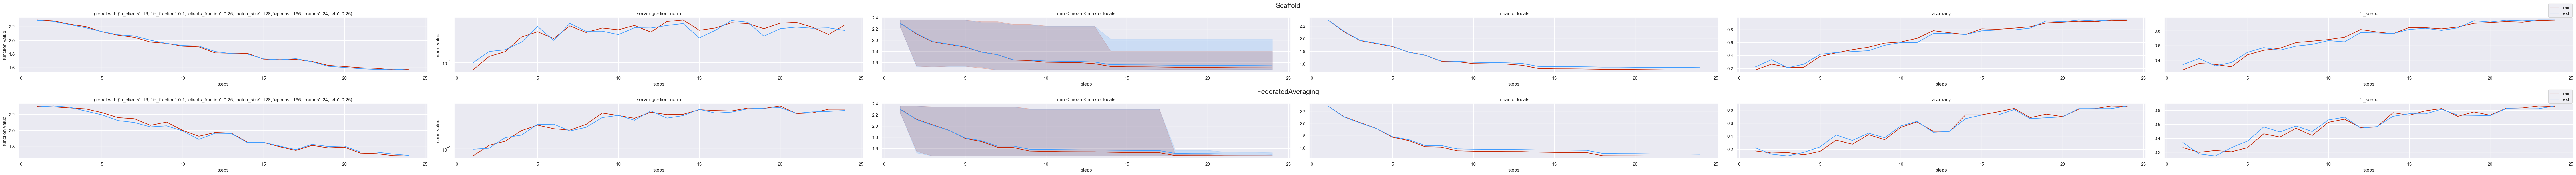

In [40]:
parameters = {
  "n_clients" : [16],
  "iid_fraction" : [0.1],
  "clients_fraction": [0.25],
  "batch_size": [128], 
  "epochs": [196], # 16, 64, 
  "rounds": [24],
  "eta": [25e-2], # , 1e-2
}
metrics = {
  "accuracy" : lambda y_proba, y_true: accuracy_score(np.argmax(y_proba, axis=1), y_true),
  "f1_score" : lambda y_proba, y_true: f1_score(np.argmax(y_proba, axis=1), y_true, average="weighted")
}

pipeline = Pipeline(
  function=function,
  optimizers=[Scaffold, FederatedAveraging],
  metrics=metrics,
  parameters=parameters,
  distributor=distributor,
  X=X,
  y=y,
  executor=threadpool
)

best, best_params = pipeline.run(
  choose_best_by="accuracy",
  scaled=False, 
  reducers=[mean()]
)

print("done")

In [ ]:
best.clients[0].X.shape

(9, 64)

In [37]:
client_X = distributor.distribute(X, y, 16, iid_fraction=0.1)["train"]["X"]["clients"][7]
client_X.shape

(72, 64)

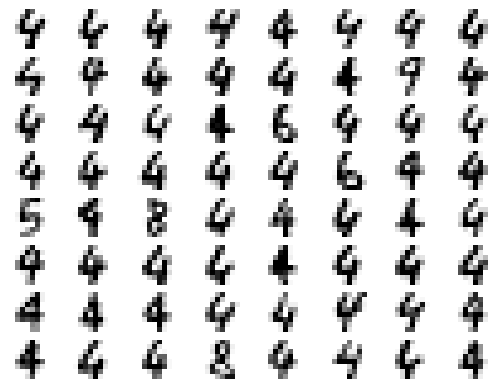

In [38]:
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(client_X[i].reshape(8, 8), cmap='Greys')

In [90]:
[print(client.function.weights()) for client in best.clients]
best.server.function.weights()

[-0.00632924 -0.07750867  0.05834913 ...  0.05340924 -0.1004592
  0.04315362]
[-0.00632924 -0.07750867  0.05844739 ...  0.05083061 -0.099429
  0.04348629]
[-0.00632924 -0.07751163  0.0584022  ...  0.05635291 -0.10035957
  0.04015091]
[-0.00632924 -0.07750888  0.05825634 ...  0.05354346 -0.09921396
  0.03808052]
[-0.00632924 -0.07750972  0.05825907 ...  0.05638725 -0.09847958
  0.04016912]
[-0.00632924 -0.07750867  0.05829315 ...  0.05056216 -0.10016945
  0.04117713]
[-0.00632924 -0.07750867  0.05821497 ...  0.05354665 -0.10045183
  0.04028152]
[-0.00632924 -0.07750972  0.05831816 ...  0.05058753 -0.1001277
  0.04313825]
[-0.00632924 -0.07750984  0.05825518 ...  0.05121563 -0.09806246
  0.03890089]
[-0.00632924 -0.07750867  0.05825831 ...  0.05109507 -0.09928871
  0.03885296]
[-0.00632924 -0.07750888  0.05824756 ...  0.05340882 -0.10022093
  0.03818086]
[-0.00632924 -0.07750867  0.05828879 ...  0.05100909 -0.09822037
  0.03865002]
[-0.00632924 -0.0775108   0.05821472 ...  0.05065565 -0.

array([-0.00632924, -0.07750785,  0.05832164, ...,  0.05328247,
       -0.09956715,  0.04034502])

In [112]:
[print(client.function.weights()) for client in best.clients]
best.server.function.weights()

[[142.0016919 ]
 [-75.02002154]]
[[127.39913808]
 [-70.78454039]]
[[102.99203914]
 [-51.46918268]]
[[112.93484916]
 [-75.03022149]]
[[ 91.54016144]
 [-41.22262259]]
[[101.11477827]
 [-92.22814237]]
[[ 70.76814066]
 [-81.67070571]]
[[ 97.69115845]
 [-55.94135101]]
[[ 97.53543694]
 [-31.76528234]]
[[ 82.13731275]
 [-40.42370448]]
[[ 90.65189836]
 [-31.4266212 ]]
[[ 81.7892518 ]
 [-26.08344735]]
[[ 68.21018323]
 [-55.05404996]]
[[ 62.15020107]
 [-63.83993616]]
[[ 74.31095289]
 [-37.49867611]]
[[ 72.15864969]
 [-48.69941825]]
[[ 76.48995736]
 [-36.32398436]]
[[ 81.54803162]
 [-16.09861949]]
[[ 69.73842697]
 [-24.26800728]]
[[ 72.60881105]
 [-22.6713205 ]]
[[ 77.30665952]
 [-18.23121831]]
[[ 59.58454636]
 [-53.7163905 ]]
[[ 64.02374074]
 [-29.54586836]]
[[ 53.52529254]
 [-38.40949464]]
[[ 54.26651857]
 [-42.91190049]]
[[ 65.12236034]
 [-35.88809011]]
[[ 65.78065382]
 [-20.82636061]]
[[64.79789989]
 [-7.19074308]]
[[ 54.84618004]
 [-41.74501908]]
[[ 55.98256315]
 [-15.3577822 ]]
[[ 54.456862

array([[41.93488277],
       [35.42677041]])

In [113]:
best_params

{'clients_fraction': 0.3, 'batch_size': 64, 'epochs': 128, 'eta': 0.001}

  MSE: 18028.008939559943
  MAE: 107.54545703886623
  MAPE: 2.56955305725453


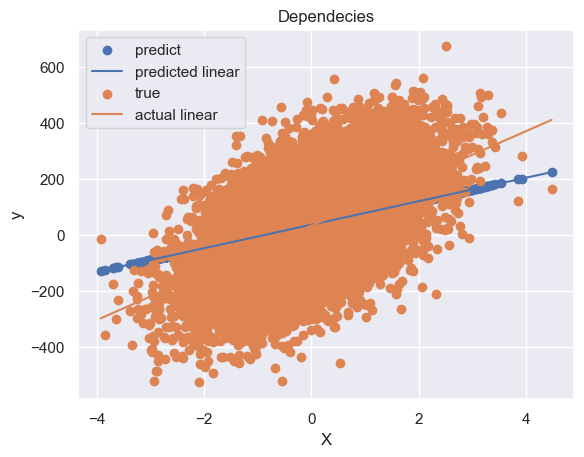

In [115]:
if n_features == 1 and n_targets == 1:
  draw_linear(
    X, y, np.array([*coeff_actual, bias_actual]),
    best.server.function.predict(X), best.server.function.weights()
  )
print(f"\
  MSE: {mean_squared_error(y, best.server.function.predict(X))}\n\
  MAE: {mean_absolute_error(y, best.server.function.predict(X))}\n\
  MAPE: {mean_absolute_percentage_error(y, best.server.function.predict(X))}\
")

In [ ]:
import torch

In [ ]:
torch.vstack((torch.Tensor([1]), torch.Tensor([1])))

tensor([[1.],
        [1.]])

In [ ]:
a = torch.arange(1, 4 * 5 + 1)
b = torch.arange(1, 4 * 1 + 1)
a, b

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20]),
 tensor([1, 2, 3, 4]))

In [ ]:
torch.cat((a, b)).shape

torch.Size([24])

In [ ]:
a[[[1, 2, 3], [2, 2, 2]]]

tensor([ 8, 13, 18])

In [230]:
def _by_norm2(data: np.ndarray):
  return np.linalg.norm(data, ord=2, axis=1)

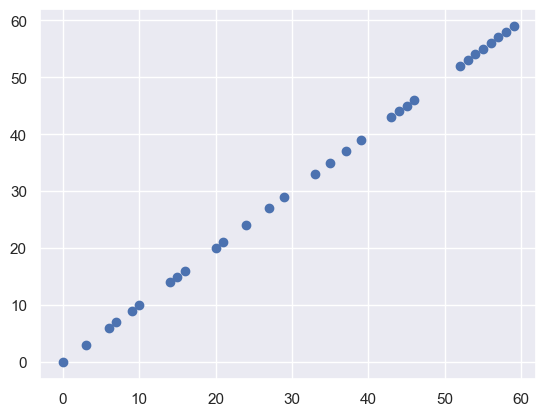

In [231]:
iid_fraction = 0.5
n_samples = 60

def _iid_size(total: int):
  return int(iid_fraction * total)

X = np.arange(0, n_samples).reshape((n_samples, 1))
y = np.arange(0, n_samples).reshape((n_samples, 1))

indices = np.arange(0, n_samples)
np.random.shuffle(indices)

iid = indices[:_iid_size(len(indices))]
X_iid = X[iid]
y_iid = y[iid]

plt.scatter(X_iid, y_iid)

In [232]:
non_iid = indices[_iid_size(len(indices)):]

y_non_iid = y[non_iid]
X_non_iid = X[non_iid]
sorted_non_iid = np.argsort(_by_norm2(y_non_iid))

y_non_iid = y_non_iid[sorted_non_iid]
X_non_iid = X_non_iid[sorted_non_iid]

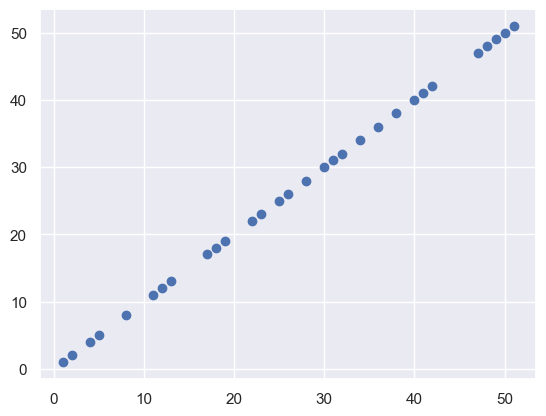

In [233]:
X_non_iid = X[non_iid]
y_non_iid = y[non_iid]
plt.scatter(X_non_iid, y_non_iid)

In [234]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [287]:
from common.distributor import (
  DataDistributor
)
from optimization.federative.fedavg import FederatedAveraging
from optimization.federative.scaffold import Scaffold

In [323]:
y.shape

(8192, 1)

In [324]:
distrotest = DataDistributor()
data = distrotest.distribute(
  X=X,
  y=y,
  n_parts=10,
  iid_fraction=0,
  test_size=0.2
)

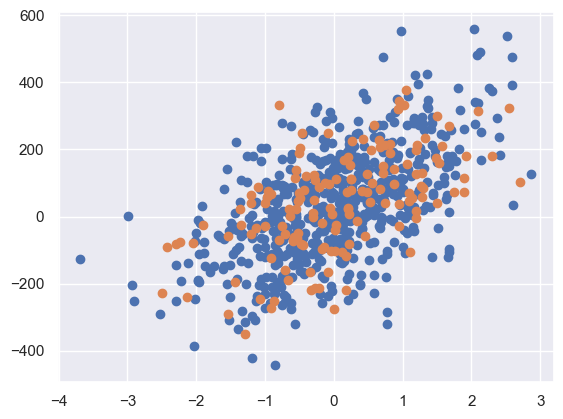

In [335]:
plt.scatter(data["train"]["X"]["server"], data["train"]["y"]["server"])
plt.scatter(data["test"]["X"]["server"], data["test"]["y"]["server"])

In [326]:
data["train"]["X"]["clients"][0].shape

(596, 1)

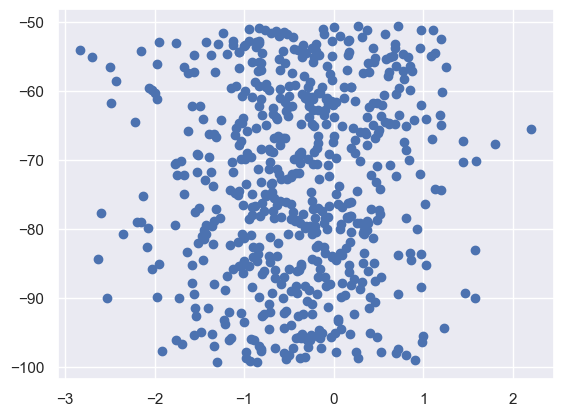

In [329]:
plt.scatter(data["train"]["X"]["clients"][2], data["train"]["y"]["clients"][2])

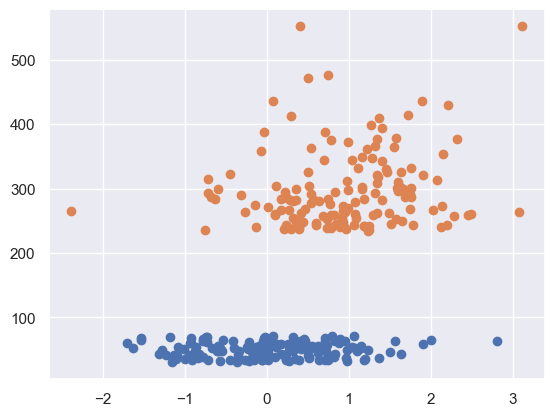

In [336]:
k = 0
for x, y in zip(data["test"]["X"]["clients"], data["test"]["y"]["clients"]):
  if k == 5 or k == 9:
    plt.scatter(x, y)
  k += 1
# k = 0
# for x, y in zip(data["test"]["X"]["clients"], data["test"]["y"]["clients"]):
#   if k == 1 or k == 3:
#     plt.scatter(x, y)
#   k += 1


In [26]:
y = np.linspace(0, 20, 100)
tensor = torch.tensor(y)
tensor.type()

'torch.DoubleTensor'